In [1]:
from dotenv import load_dotenv

# .env 파일의 환경변수를 기존 값과 상관없이 덮어쓰기
load_dotenv(override=True)

True

In [2]:
# from langchain.chat_models import ChatOpenAI
from langchain_openai import ChatOpenAI
import os


llm = ChatOpenAI(
    # model_name="deepseek/deepseek-chat:free",
    model_name="meta-llama/llama-3.3-70b-instruct:free",
    temperature=0,
    openai_api_base="https://openrouter.ai/api/v1",
    openai_api_key=os.getenv("OPENROUTER_API_KEY")
)

## Part 4.Routing

LLM 애플리케이션에서 라우팅은 입력 쿼리나 상태에 따라 적절한 처리 경로나 구성 요소로 요청을 전달하는 메커니즘입니다. 

LangChain/LangGraph에서 라우팅은 특정 작업에 가장 적합한 모델이나 도구를 선택하고, 복잡한 워크플로우를 관리하며, 비용과 성능 균형을 최적화하는 데 필수적입니다. 

**Agent**
- 도구 선택을 하는 방식으로 라우팅
- 따라서, 도구에 대한 description 이 상세하게 작성되어야 합니다.

**LLM.with_structured_output**
- Function Calling 을 사용하는 방식으로 라우팅

In [3]:
from typing import Literal
from pydantic import BaseModel, Field
from langchain_core.prompts import ChatPromptTemplate
from langchain_openai import ChatOpenAI


# 사용자 쿼리를 가장 관련성 높은 데이터 소스로 라우팅하는 데이터 모델
class RouteQuery(BaseModel):
    """Route a user query to the most relevant agent."""

    # 데이터 소스 선택을 위한 리터럴 타입 필드
    datasource: Literal["ask_city", "search_flights"] = Field(
        ...,
        description="Given a user question choose to route it to `ask_city` or a `search_flights`.",
    )


# llm 구조화된 출력 설정
structured_llm_router = llm.with_structured_output(RouteQuery)

# 프롬프트 설정
system = """You are a travel assistant expert at routing a user question.
- If the user asks about the destination, call `ask_city`.
- If the user asks about flights, call `search_flights`.
- If the user's question is unrelated to travel, respond with "I can only help with travel-related questions."

Do not provide an answer directly. Just determine which method to call.
"""

# Routing 을 위한 프롬프트 템플릿 생성
route_prompt = ChatPromptTemplate.from_messages(
    [
        ("system", system),
        ("human", "{question}"),
    ]
)

# 프롬프트 템플릿과 구조화된 LLM 라우터를 결합하여 질문 라우터 생성
question_router = route_prompt | structured_llm_router

In [4]:
question_router.invoke("비행기 표 예약해 줘")

RouteQuery(datasource='search_flights')

In [5]:
question_router.invoke("여행 일정을 알려 줘")

RouteQuery(datasource='ask_city')

---

질문 라우팅 노드의 구현입니다.

사용자의 질문에 대해 `question_router` 를 호출하여 적절한 데이터 소스로 라우팅합니다.

- `web_search`: 웹 검색
- `vectorstore`: 벡터 스토어

라우팅 결과에 따라 적절한 노드로 라우팅합니다.

In [6]:
# 질문 라우팅 노드
def route_question(state):
    print("==== [ROUTE QUESTION] ====")
    # 질문 가져오기
    question = state["question"]
    # 질문 라우팅
    source = question_router.invoke({"question": question})
    # 질문 라우팅 결과에 따른 노드 라우팅
    if source.datasource == "ask_city":
        print("\n==== [GO TO ASK CITY] ====")
        return "ask_city"
    elif source.datasource == "search_flights":
        print("\n==== [GO TO SEARCH FLIGHTS] ====")
        return "search_flights"

### 그래프 생성

이 단계에서는 `web_search`, `retrieve`, `generate` 노드를 생성하고, 이들을 연결하는 조건부 엣지를 추가합니다.

- `web_search`: 웹 검색 노드
- `retrieve`: 문서 검색 노드
- `generate`: 답변 생성 노드

조건부 엣지: 질문 라우팅 노드에서 반환된 결과에 따라 적절한 노드로 라우팅합니다.

- `need to search web`: 웹 검색 노드로 라우팅
- `search on DB`: 벡터 스토어 노드로 라우팅




In [9]:
from langgraph.graph import StateGraph, END
from typing import TypedDict, Optional, List

# 상태 정의
class TravelState(TypedDict):
    start_date: Optional[str]
    end_date: Optional[str]
    destination_city: Optional[str]
    flight_options: Optional[List[str]]


# 도시 묻는 노드
def ask_city(state: TravelState) -> TravelState:
    print("📍 여행할 도시를 입력해 주세요.")
    city = input("→ 입력: ")
    state["destination_city"] = city.strip()
    return state

# 항공편 찾는 노드
def search_flights(state: TravelState) -> TravelState:
    print(f"\n✈️ 항공편 검색 중...")
    print(f"   날짜: {state['start_date']} ~ {state['end_date']}")
    print(f"   도시: {state['destination_city']}\n")

    state["flight_options"] = [
        f"{state['start_date']} 출발 ✈️ Flight A",
        f"{state['end_date']} 귀국 ✈️ Flight B"
    ]
    return state

# 답변 생성 노드
def generate(state: TravelState) -> TravelState:
    print(f"\n🎯 여행 정보 요약:")
    print(f"   도시: {state['destination_city']}")
    print(f"   날짜: {state['start_date']} ~ {state['end_date']}")
    print(f"   항공편: {len(state['flight_options'])}개 옵션")
    
    print(f"\n📋 추천 항공편:")
    for i, flight in enumerate(state['flight_options'], 1):
        print(f"   {i}. {flight}")
    
    print(f"\n✨ 여행 계획이 완성되었습니다!")
    return state


In [12]:
from langgraph.graph import END, StateGraph, START
from langgraph.checkpoint.memory import MemorySaver

# 그래프 상태 초기화
workflow = StateGraph(TravelState)

# 노드 정의
workflow.add_node("ask_city", ask_city)
workflow.add_node("search_flights", search_flights)
workflow.add_node("generate", generate)

# 그래프 빌드
workflow.add_conditional_edges(
    START,
    route_question,
    {
        "ask city": "ask_city",  # 웹 검색으로 라우팅
        "search flight": "search_flights",  # 벡터스토어로 라우팅
    },
)
workflow.add_edge("ask_city", "generate")  # 문서 검색 후 답변 생성
workflow.add_edge("search_flights", "generate")  # 웹 검색 후 답변 생성
workflow.add_edge("generate", END)  # 답변 생성 후 종료


# 그래프 컴파일
travel_graph = workflow.compile(checkpointer=MemorySaver())

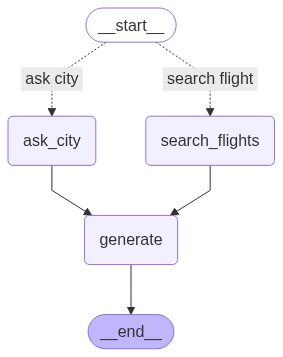

In [13]:
from IPython.display import Image, display
# Mermaid 시각화
try:
    display(Image(travel_graph.get_graph().draw_mermaid_png()))
except Exception as e:
    print("그래프 시각화 실패:", e)
    print(travel_graph.get_graph().draw_mermaid())  # 소스코드 출력

In [16]:
from langchain.chat_models import ChatOpenAI
from langchain.output_parsers import PydanticOutputParser
from pydantic import BaseModel
import os

# Pydantic 파서 생성
parser = PydanticOutputParser(pydantic_object=RouteQuery)

# LLM 실행 및 파싱
def structured_llm_router(query: str):
    prompt = f"Classify this query into an action: '{query}'\nReturn the output as JSON in this format: {parser.get_format_instructions()}"
    response = llm.invoke(prompt)  # LLM 호출
    parsed_result = parser.parse(response.content)  # JSON 파싱
    return parsed_result

# 테스트 실행
query = "비행기 예약해줘."
result = structured_llm_router(query)
result


RouteQuery(action='book_flight')